Dask Approach to Non-SQL PTM Queries
--

v01: move away from classes, try to organize the computation 
primarily in dask.

In [1]:
import postproc_dask as post
import six

In [2]:
try:
    client.close()
except NameError:
    pass

In [3]:
import multiprocessing.popen_spawn_posix #  https://github.com/dask/distributed/issues/4168
import dask
import dask.dataframe as dd
import dask.bag as db

from dask.distributed import Client
client=Client(n_workers=8,threads_per_worker=1)
client.cluster

In [4]:
import matplotlib.pyplot as plt
import conc_figure
import six
import stompy.plot.cmap as scmap
from stompy.spatial import proj_utils
from matplotlib import cm
cmap=cm.CMRmap_r
cmap=scmap.cmap_clip(cmap,0.03,1.0)

%matplotlib notebook

In [5]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import re

from stompy.grid import unstructured_grid
from stompy import utils, memoize
from stompy.model.fish_ptm import ptm_config, ptm_tools
from stompy.model.suntans import sun_driver
from scipy.stats import spearmanr

import stompy.plot.cmap as scmap
from scipy import stats
import seaborn as sns
turbo=scmap.load_gradient('turbo.cpt')

Overall Process
===

1. SUNTANS hydro runs
2. SUNTANS average output
3. ptm-formatted average output
4. PTM runs
5. Load data

The top-level query is something like *generate a map of concentrations for...*

filter on:
 - sources $x$
 - settling classes $y$
 - vertical positions $z$
 - horizontal positions $h$

weighted by

 - loading data 
 - age
 
mapped by one of ...

 - bounding box
 - put on hydro grid
 - put on regular grid

and possibly smoothed.

In [6]:
# Experiment level configuration -- small, all python native data.
cfg=dict(
    ptm_base_dir="/opt2/sfb_ocean/ptm/all_source_022b",
    sun_base_dir="/opt2/sfb_ocean/suntans/runs",
    ptm_output_interval=np.timedelta64(1,'h')
)
cfg['ptm_run_patt']=os.path.join(cfg['ptm_base_dir'],"chunk??","20??????")
cfg['sun_patt']=os.path.join(cfg['sun_base_dir'],"merged_022_20??????")

ptm_run_paths=glob.glob(cfg['ptm_run_patt'])
ptm_run_paths.sort()
cfg['ptm_run_paths']=ptm_run_paths

sun_paths=glob.glob(cfg['sun_patt'])
sun_paths.sort()
cfg['sun_paths']=sun_paths

In [7]:
# Load the grid into... grid
hydro_path=sun_paths[0]
ptm_ds=xr.open_dataset(os.path.join(hydro_path,"ptm_average.nc_0000.nc"))
grid=unstructured_grid.UnstructuredGrid.read_ugrid(ptm_ds,dialect='fishptm')
ptm_ds.close()   

# distribute to workers ahead of time.
grid_d=client.scatter(grid)
cfg['grid_d']=grid_d # too far?

In [8]:
# So far this is only used locally.  Slow to compute (15s)
Msmooth=grid.smooth_matrix()
Msmooth_K=grid.smooth_matrix(K=100*np.ones(grid.Nedges()))

INFO:utils:61953/99089
INFO:utils:62689/99089


In [9]:
# Or could make this delayed and have it execute on each client?
load_data_d=client.scatter(post.get_load_data())
cfg['load_data_d']=load_data_d


In [10]:
# Hydro timestamps
cfg['hydro_timestamps']=post.load_hydro_timestamps(sun_paths)


In [11]:
bc_ds_d=client.scatter(post.bc_ds(cfg=cfg))
cfg['bc_ds_d']=bc_ds_d

In [12]:
areas=grid.cells_area()    

Next steps
--


1. Recreate some of the figures from before, including on-grid smoothing.  
  a. Sample plot: from the powerpoint. 2017-08-30 to 2017-09-14. Surface particles
     max age of 10 days.   *This plot is similarish -- not exactly the same but close
     enough to rule out fundamental errors*
2. Pull out manta samples as before. Maybe skip putting it on the grid, just
   query a radius.
  a. Implement in this notebook
  b. Move all of this to a module.

In [13]:
ll2utm=proj_utils.mapper('WGS84','EPSG:26910')
# Load the manta data, clean it up
manta_fn='manta_summary-v03.csv'
manta=pd.read_csv(manta_fn)
manta.head()

,SampleID,SAMPLE LOCATION,DATE,TYPE,LAT START,LONG START,LAT END,LONG END,TOTAL DIST (M),START FLOW,...,part_per_m3_std,part_per_m2_std,part_per_m3_raw_std,part_per_m2_raw_std,part_per_m3_nofiber,part_per_m2_nofiber,part_per_m3_raw_nofiber,part_per_m2_raw_nofiber,x,y
0,CB-4-Manta-21Aug2017,CB4,2017-08-21 00:00:00,Manta,37.915567,-122.441217,37.941933,-122.419983,3473.323262,NaN,...,0.224191,0.021298,0.442172,0.042006,0.015526,0.001475,0.024841,0.002360,550040.331073,4.198063e+06
1,SPB3-Manta-21Aug2017,SPB3,2017-08-21 00:00:00,Manta,38.023072,-122.371583,38.042133,-122.321883,66678.222270,9113.0,...,1.817781,0.172689,1.928407,0.183199,0.296678,0.028184,0.301706,0.028662,557329.971756,4.209634e+06
2,SUB1-Manta-21Aug2017,SUB1,2017-08-21 00:00:00,Manta,38.107067,-122.056283,38.096533,-122.064917,1393.740434,128369.0,...,NaN,NaN,0.000000,0.000000,0.032671,0.003104,0.039205,0.003724,582363.556136,4.217527e+06
3,SPB2-Manta-21Aug2017,SPB2,2017-08-21 00:00:00,Manta,38.051283,-122.421750,38.023000,-122.428117,3194.008847,220135.0,...,0.210549,0.020002,0.402882,0.038274,0.021966,0.002087,0.034288,0.003257,550464.046320,4.210092e+06
4,CB9-Manta-22Aug2017,CB9,2017-08-22 00:00:00,Manta,37.687233,-122.290917,37.698500,-122.298433,1416.656380,290000.0,...,0.085947,0.008165,0.174186,0.016548,0.085947,0.008165,0.091677,0.008709,562183.425087,4.171973e+06


In [14]:
godwin_offset_h=post.godwin_offset_h
godwin=post.godwin

In [15]:
cfg['manta_out_dir']="manta_sets_20210317b"


# now the 021b runs.
# c suffix: use tighter -0.095 z filter.
# 20200227: start of v03
# 20200302: start of v04
# 20200305: try larger window -- extra 24 hours in both directions.
# 20200312: new sources in ptm data, with v02 stormwater concs.
# 20200330: more new sources.
# 20210210a: dask code, new hydro, new ptm. new year.
# 20210317a: new ptm runs with no SJ loss...
#            has the w_s bug
# 20210317b: fixed w_s bug
os.makedirs(cfg['manta_out_dir'],exist_ok=True)

In [16]:
def predict_mantas_multi(manta,taus,
                         Msmooths=[Msmooth],
                         steps=[30],
                         storm_factors=[0.05],
                         cfg=cfg):
    # manta: pd.DataFrame 
    # tau: np.timedelta64 giving e-folding time scale
    # of loss.
    # storm_factor: scale stormwater concentrations by this
    #  factor.
    preds=[]
    
    # Force mantas to be sorted, so that data from the same day
    # is grouped together.
    manta=manta.sort_values('DATE')
    last_DATE=None
    df=None

    for idx,rec in utils.progress(manta.iterrows()):
        print(idx)
        # since we're just pulling out whole days, cache by day.
        # and pull through the end of that day
        # 5s, all in read_parquet
        if rec.DATE==last_DATE:
            pass
        else:
            df=post.particles_for_date(rec.DATE,cfg=cfg)
            last_DATE=rec.DATE

        # Trawl-specific processing:
        # Pull subset of cells
        # add a cell weighting, and a time weighting for the tidal filter
        for Msmooth_i,Msmooth in enumerate(Msmooths):
            print(f"  smooth: {Msmooth_i}")
            for step in steps:
                print(f"    steps: {step}")
                cells,weights=post.rec_to_cell_weights(rec,areas=areas,grid=grid,
                                                       Msmooth=Msmooth,smooth=step,thresh=1e-5)
                df_spatial=pd.DataFrame(dict(cell=cells,weight_spatial=weights)).set_index('cell')
                # 1.3s. selecting a subset of rows, and adding a column with spatial weight.
                # Using a dictionary might get this down to 60% of original
                # going through numpy  might get down to 40% of original.
                if 0:
                    tdf=df.join(df_spatial,on='cell',how='inner')
                else:
                    # trying numpy approach
                    df_spatial_sort=df_spatial.sort_index()
                    space_cell=df_spatial_sort.index.values
                    space_weight=df_spatial_sort['weight_spatial'].values
                    df_cell=df.cell.values
                    df_idx=np.searchsorted(space_cell,df_cell).clip(0,len(space_cell)-1)
                    sel=space_cell[df_idx]==df_cell
                    tdf=df[sel].copy()
                    tdf['weight_spatial']=space_weight[df_idx[sel]]                    

                t_sample=np.datetime64(rec['DATE'])    
                t_center = t_sample+np.timedelta64(8,'h') + np.timedelta64(12,'h')
                delta_hours=((tdf['time']-t_center)/np.timedelta64(1,'h')).astype(np.int32)
                weight_time=godwin[delta_hours+godwin_offset_h]
                age=tdf['time'] - tdf['rel_time']
    
                for storm_factor in storm_factors:
                    print(f"      storm_factor: {storm_factor}")
                    group_weight=post.group_weights(tdf,storm_factor)

                    for tau in taus:
                        tau_s=tau/np.timedelta64(86400,'s')
                        print(f"        tau={tau_s} days")
                        pred=dict(idx=idx,storm_factor=storm_factor,tau=tau,step=step,
                                  Msmooth_i=Msmooth_i)
                        pred['idx']=idx

                        if tau_s>0:
                            decay=np.exp( -age/tau )
                        else:
                            decay=1.0
                        weights=tdf['weight_spatial']*weight_time*decay*group_weight

                        # tdf['mp_per_particle'] # the number of physical particles represented by the virtual particle
                        #   This is the contribution from this one
                        #   virtual particle the cell concentration
                        C=( weights * tdf['mp_per_particle'] / areas[tdf['cell']] ).sum()
                        pred['C_model']=C
                        preds.append(pred)

    df_pred=pd.DataFrame(preds)
    manta_pred=df_pred.join(manta,on='idx')
    return manta_pred

In [17]:
def metrics(grp):
    obs=grp['part_per_m2_nofiber'].values
    mod=grp['C_model'].values
    
    skill={}
    skill['rho'],p=spearmanr(obs, mod)
    skill['norm_std']=mod.std() / obs.std()
    skill['norm_mag']=mod.mean() / obs.mean()
    skill['rel_std_obs']=obs.std() / obs.mean()
    skill['rel_std_mod']=mod.std() / mod.mean()
    
    # Same but drop top/bottom 2 outliers:
    obs_rank=np.argsort(np.argsort(obs))
    sel=(obs_rank>2)&(obs_rank<len(obs)-2)
    r=np.corrcoef(obs[sel], mod[sel])[0,1]
    skill['r_sub']=r
    
    skill['norm_std_sub']=mod[sel].std() / obs[sel].std()
    skill['norm_mag_sub']=mod[sel].mean() / obs[sel].mean()
    skill['rel_std_obs_sub']=obs[sel].std() / obs[sel].mean()
    skill['rel_std_mod_sub']=mod[sel].std() / mod[sel].mean()

    return pd.Series(skill)
   

In [18]:
if 0:
    # Evaluate effect of smoothing on correlation metrics
    # This one testing evaluation of multiple smooths, steps,
    # tau, etc. in one call.
    taus=[np.timedelta64(int(25*86400),'s')]
    Msmooths=[Msmooth,Msmooth_K]
    mtypes=['grid','constant']
    steps=[0,-10,-100,-1000,-10000,-100000]

    manta_pred=predict_mantas_multi(manta,taus=taus,
                                    Msmooths=Msmooths,
                                    steps=steps,
                                    storm_factors=[1.0])
    manta_pred['Msmooth_label']=[ mtypes[i] for i in manta_pred['Msmooth_i'].values]

    manta_pred.groupby(['Msmooth_label','step','tau','storm_factor']).apply(metrics)

    taus=[np.timedelta64(int(d*86400),'s') for d in [1,2,5,10,20,30,45,60]]
    Msmooths=[Msmooth]
    mtypes=['grid']
    steps=[-10000]

    manta_pred_tau=predict_mantas_multi(manta,taus=taus,
                                        Msmooths=Msmooths,
                                        steps=steps,
                                        storm_factors=[1])
    manta_pred_tau['Msmooth_label']=[ mtypes[i] for i in manta_pred_tau['Msmooth_i'].values]

    manta_pred_tau.groupby(['Msmooth_label','step','tau','storm_factor']).apply(metrics)

In [19]:
# Master set of predictions
taus=[np.timedelta64(int(d*86400),'s') for d in [5,10,20,30,60]]
Msmooths=[Msmooth,Msmooth_K]
mtypes=['grid','constant']
steps=[0,-10,-1000,-10000,-100000]
storm_factors=[0.,0.01,0.05,0.2,1.0]

In [20]:
manta_pred_master=predict_mantas_multi(manta,taus=taus,
                                       Msmooths=Msmooths,
                                       steps=steps,
                                       storm_factors=storm_factors)
manta_pred_master['Msmooth_label']=[ mtypes[i] for i in manta_pred_master['Msmooth_i'].values]

manta_pred_master.groupby(['Msmooth_label','step','tau','storm_factor']).apply(metrics)

0
Will repartition with 242 partitions
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        t

INFO:utils:1


        tau=60.0 days
1
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
  

INFO:utils:2


        tau=60.0 days
2
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
  

INFO:utils:3


        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
3
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
   

INFO:utils:4


        tau=30.0 days
        tau=60.0 days
4
Will repartition with 242 partitions
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        t

INFO:utils:5


        tau=30.0 days
        tau=60.0 days
5
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
  

INFO:utils:6


6
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05

INFO:utils:7


7
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05

INFO:utils:8


11
Will repartition with 242 partitions
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        

INFO:utils:9


        tau=30.0 days
        tau=60.0 days
10
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
 

INFO:utils:10


        tau=30.0 days
        tau=60.0 days
8
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
  

INFO:utils:11


        tau=30.0 days
        tau=60.0 days
9
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
  

INFO:utils:12


        tau=30.0 days
        tau=60.0 days
12
Will repartition with 242 partitions
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        

INFO:utils:13


        tau=60.0 days
13
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
 

INFO:utils:14


        tau=60.0 days
14
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
 

INFO:utils:15


        tau=30.0 days
        tau=60.0 days
15
Will repartition with 242 partitions
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        

INFO:utils:16


        tau=60.0 days
16
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
 

INFO:utils:17


        tau=60.0 days
17
Will repartition with 242 partitions
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        

INFO:utils:18


        tau=60.0 days
18
Will repartition with 242 partitions
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        

INFO:utils:19


        tau=60.0 days
19
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
 

INFO:utils:20


        tau=60.0 days
20
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
 

INFO:utils:21


        tau=60.0 days
21
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
 

INFO:utils:22


        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
22
Will repartition with 242 partitions
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm

INFO:utils:23


        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
23
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
 

INFO:utils:24


24
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.0

INFO:utils:25


        tau=60.0 days
25
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
 

INFO:utils:26


26
Will repartition with 277 partitions
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        

INFO:utils:27


27
Will repartition with 277 partitions
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        

INFO:utils:28


28
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.0

INFO:utils:29


        tau=30.0 days
        tau=60.0 days
29
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
 

INFO:utils:30


30
Will repartition with 277 partitions
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        

INFO:utils:31


31
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.0

INFO:utils:32


        tau=60.0 days
37
Will repartition with 277 partitions
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        

INFO:utils:33


36
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.0

INFO:utils:34


        tau=60.0 days
35
  smooth: 0
    steps: 0
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.05
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.2
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 1.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
    steps: -10
      storm_factor: 0.0
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
      storm_factor: 0.01
        tau=5.0 days
        tau=10.0 days
        tau=20.0 days
        tau=30.0 days
        tau=60.0 days
 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [21]:
manta_pred_master['tau']=manta_pred_master['tau']/np.timedelta64(86400,'s')
manta_pred_master.to_parquet('manta_pred_master.parquet')

In [23]:
all_metrics=manta_pred_master.groupby(['Msmooth_label','step','tau','storm_factor']).apply(metrics)

In [26]:
# Best overall rho:
#  tau=5, storm=1, grid smooth, step=-100000 => rho=0.74
#  insensitive to tau. mag still something like 14x too large for tau=60,
#  interestingly, even with tau=5, magnitude still 7x too large.
all_metrics.sort_values('rho',ascending=False).head(10)

rho   norm_std   norm_mag  \
Msmooth_label step    tau  storm_factor                                   
grid          -100000 5.0  1.0           0.741914   4.895843   6.995244   
                      10.0 1.0           0.739685   6.800444   9.786014   
                      30.0 1.0           0.733872   8.598415  13.364001   
                      60.0 1.0           0.730638   9.150302  14.882390   
                      20.0 1.0           0.729152   8.094624  12.197932   
              -10000  5.0  1.0           0.728584   8.227549   9.269318   
                      10.0 1.0           0.719056  11.373421  12.961857   
              -100000 10.0 0.2           0.715297   1.370709   2.239417   
              -10000  30.0 1.0           0.712762  14.301680  17.517809   
              -100000 20.0 0.2           0.712631   1.631564   2.820686   

                                         rel_std_obs  rel_std_mod     r_sub  \
Msmooth_label step    tau  storm_factor                                       
grid          -100000 5.0  1.0              4.739295     3.316946  0.539048   
                      10.0 1.0              4.739295     3.293405  0.538436   
                      30.0 1.0              4.739295     3.049268  0.543681   
                      60.0 1.0              4.739295     2.913912  0.547198   
                      20.0 1.0              4.739295     3.145026  0.541388   
              -10000  5.0  1.0              4.739295     4.206651  0.534279   
                      10.0 1.0              4.739295     4.158509  0.534384   
              -100000 10.0 0.2              4.739295     2.900843  0.541261   
              -10000  30.0 1.0              4.739295     3.869199  0.538810   
              -100000 20.0 0.2              4.739295     2.741342  0.544628   

                                         norm_std_sub  norm_mag_sub  \
Msmooth_label step    tau  storm_factor                               
grid          -100000 5.0  1.0              42.223629     18.717190   
                      10.0 1.0              58.652728     26.286070   
                      30.0 1.0              74.137788     36.041279   
                      60.0 1.0              78.879079     40.190376   
                      20.0 1.0              69.803268     32.857539   
              -10000  5.0  1.0              71.128535     25.447823   
                      10.0 1.0              98.319541     35.632717   
              -100000 10.0 0.2              11.813641      6.012382   
              -10000  30.0 1.0             123.605880     48.172026   
              -100000 20.0 0.2              14.059239      7.590439   

                                         rel_std_obs_sub  rel_std_mod_sub  
Msmooth_label step    tau  storm_factor                                    
grid          -100000 5.0  1.0                  1.493503         3.369156  
                      10.0 1.0                  1.493503         3.332489  
                      30.0 1.0                  1.493503         3.072173  
                      60.0 1.0                  1.493503         2.931204  
                      20.0 1.0                  1.493503         3.172831  
              -10000  5.0  1.0                  1.493503         4.174452  
                      10.0 1.0                  1.493503         4.120948  
              -100000 10.0 0.2                  1.493503         2.934563  
              -10000  30.0 1.0                  1.493503         3.832220  
              -100000 20.0 0.2                  1.493503         2.766312

In [27]:
# Best r_sub is also grid smoothed, step=-100000, but now
# tau=60.0. Again, not very sensitive to tau or storm_factor.
all_metrics.sort_values('r_sub',ascending=False).head(10)

rho  norm_std   norm_mag  \
Msmooth_label step    tau  storm_factor                                  
grid          -100000 60.0 0.05          0.671285  0.480752   1.362717   
                      30.0 0.05          0.674432  0.450845   1.188673   
                      20.0 0.05          0.670455  0.423917   1.062453   
                      60.0 0.20          0.694493  1.844808   3.497403   
                           1.00          0.730638  9.150302  14.882390   
                      30.0 0.20          0.706643  1.733274   3.111094   
                      10.0 0.05          0.682386  0.355846   0.824430   
                      5.0  0.05          0.680594  0.257458   0.583137   
                      20.0 0.20          0.712631  1.631564   2.820686   
                      30.0 1.00          0.733872  8.598415  13.364001   

                                         rel_std_obs  rel_std_mod     r_sub  \
Msmooth_label step    tau  storm_factor                                       
grid          -100000 60.0 0.05             4.739295     1.671973  0.558218   
                      30.0 0.05             4.739295     1.797540  0.554091   
                      20.0 0.05             4.739295     1.890971  0.551214   
                      60.0 0.20             4.739295     2.499881  0.550961   
                           1.00             4.739295     2.913912  0.547198   
                      30.0 0.20             4.739295     2.640390  0.547145   
                      10.0 0.05             4.739295     2.045607  0.546819   
                      5.0  0.05             4.739295     2.092426  0.545154   
                      20.0 0.20             4.739295     2.741342  0.544628   
                      30.0 1.00             4.739295     3.049268  0.543681   

                                         norm_std_sub  norm_mag_sub  \
Msmooth_label step    tau  storm_factor                               
grid          -100000 60.0 0.05              4.126558      3.662620   
                      30.0 0.05              3.871388      3.193265   
                      20.0 0.05              3.641079      2.852858   
                      60.0 0.20             15.890285      9.430160   
                           1.00             78.879079     40.190376   
                      30.0 0.20             14.933361      8.379793   
                      10.0 0.05              3.057315      2.211065   
                      5.0  0.05              2.211315      1.561264   
                      20.0 0.20             14.059239      7.590439   
                      30.0 1.00             74.137788     36.041279   

                                         rel_std_obs_sub  rel_std_mod_sub  
Msmooth_label step    tau  storm_factor                                    
grid          -100000 60.0 0.05                 1.493503         1.682683  
                      30.0 0.05                 1.493503         1.810664  
                      20.0 0.05                 1.493503         1.906146  
                      60.0 0.20                 1.493503         2.516627  
                           1.00                 1.493503         2.931204  
                      30.0 0.20                 1.493503         2.661525  
                      10.0 0.05                 1.493503         2.065118  
                      5.0  0.05                 1.493503         2.115341  
                      20.0 0.20                 1.493503         2.766312  
                      30.0 1.00                 1.493503         3.072173

In [29]:
# Best magnitudes, including obs. outliers?
# This is all the place. Chooses some very noisy options,
# probably just happenstance to get close.  All pretty low rho
# and r_sub.
all_metrics['norm_mag_err']=np.abs(all_metrics['norm_mag']-1)
all_metrics.sort_values('norm_mag_err').head(10)

rho  norm_std  norm_mag  \
Msmooth_label step   tau  storm_factor                                 
grid          -1000  30.0 0.01          0.403890  0.245825  1.001926   
constant      -1000  60.0 0.01          0.380332  0.267447  1.012565   
              -10    60.0 0.01          0.368400  0.267472  1.015422   
grid           0     60.0 0.01          0.368400  0.267714  1.016094   
constant       0     60.0 0.01          0.368400  0.267714  1.016094   
grid          -1000  10.0 0.05          0.538024  0.286362  0.974795   
              -10    60.0 0.00          0.217045  0.269484  0.962747   
constant      -10000 60.0 0.00          0.271678  0.279643  0.961031   
grid          -1000  60.0 0.00          0.251617  0.276722  1.044499   
              -10000 60.0 0.01          0.522509  0.219557  1.046084   

                                        rel_std_obs  rel_std_mod     r_sub  \
Msmooth_label step   tau  storm_factor                                       
grid          -1000  30.0 0.01             4.739295     1.162797  0.037797   
constant      -1000  60.0 0.01             4.739295     1.251782  0.051616   
              -10    60.0 0.01             4.739295     1.248377  0.081428   
grid           0     60.0 0.01             4.739295     1.248678  0.083178   
constant       0     60.0 0.01             4.739295     1.248678  0.083178   
grid          -1000  10.0 0.05             4.739295     1.392248  0.376282   
              -10    60.0 0.00             4.739295     1.326586 -0.034934   
constant      -10000 60.0 0.00             4.739295     1.379053 -0.041678   
grid          -1000  60.0 0.00             4.739295     1.255594 -0.094696   
              -10000 60.0 0.01             4.739295     0.994706  0.370283   

                                        norm_std_sub  norm_mag_sub  \
Msmooth_label step   tau  storm_factor                               
grid          -1000  30.0 0.01              2.103631      2.646336   
constant      -1000  60.0 0.01              2.277237      2.666277   
              -10    60.0 0.01              2.276665      2.673365   
grid           0     60.0 0.01              2.278762      2.675257   
constant       0     60.0 0.01              2.278762      2.675257   
grid          -1000  10.0 0.05              2.456667      2.627151   
              -10    60.0 0.00              2.284677      2.515959   
constant      -10000 60.0 0.00              2.385936      2.522132   
grid          -1000  60.0 0.00              2.371765      2.737650   
              -10000 60.0 0.01              1.868853      2.789460   

                                        rel_std_obs_sub  rel_std_mod_sub  \
Msmooth_label step   tau  storm_factor                                     
grid          -1000  30.0 0.01                 1.493503         1.187219   
constant      -1000  60.0 0.01                 1.493503         1.275584   
              -10    60.0 0.01                 1.493503         1.271883   
grid           0     60.0 0.01                 1.493503         1.272154   
constant       0     60.0 0.01                 1.493503         1.272154   
grid          -1000  10.0 0.05                 1.493503         1.396586   
              -10    60.0 0.00                 1.493503         1.356212   
constant      -10000 60.0 0.00                 1.493503         1.412854   
grid          -1000  60.0 0.00                 1.493503         1.293898   
              -10000 60.0 0.01                 1.493503         1.000602   

                                        norm_mag_err  
Msmooth_label step   tau  storm_factor                
grid          -1000  30.0 0.01              0.001926  
constant      -1000  60.0 0.01              0.012565  
              -10    60.0 0.01              0.015422  
grid           0     60.0 0.01              0.016094  
constant       0     60.0 0.01              0.016094  
grid          -1000  10.0 0.05              0.025205  
              -10    60.0 0.00              0.037

In [30]:
# These mostly toss stormwater entirely.
# Again, poor rho and r_sub values.
all_metrics['norm_mag_sub_err']=np.abs(all_metrics['norm_mag_sub']-1)
all_metrics.sort_values('norm_mag_sub_err').head(10)

rho  norm_std  norm_mag  \
Msmooth_label step    tau  storm_factor                                 
grid          -100000 10.0 0.00          0.562194  0.058051  0.352767   
constant      -1000   5.0  0.00          0.326705  0.127244  0.390129   
grid          -10     5.0  0.00          0.313680  0.125366  0.392532   
constant      -10000  5.0  0.00          0.333392  0.125228  0.395321   
              -10     5.0  0.00          0.328934  0.131222  0.396263   
grid           0      5.0  0.00          0.335402  0.131429  0.396469   
constant       0      5.0  0.00          0.335402  0.131429  0.396469   
grid          -1000   5.0  0.00          0.328540  0.116864  0.412917   
              -10000  5.0  0.00          0.458173  0.073153  0.336635   
                           0.01          0.530114  0.110876  0.425961   

                                         rel_std_obs  rel_std_mod     r_sub  \
Msmooth_label step    tau  storm_factor                                       
grid          -100000 10.0 0.00             4.739295     0.779894  0.202286   
constant      -1000   5.0  0.00             4.739295     1.545757  0.001561   
grid          -10     5.0  0.00             4.739295     1.513630 -0.002745   
constant      -10000  5.0  0.00             4.739295     1.501290 -0.016213   
              -10     5.0  0.00             4.739295     1.569408  0.008726   
grid           0      5.0  0.00             4.739295     1.571074  0.008936   
constant       0      5.0  0.00             4.739295     1.571074  0.008936   
grid          -1000   5.0  0.00             4.739295     1.341315 -0.045925   
              -10000  5.0  0.00             4.739295     1.029875  0.004620   
                           0.01             4.739295     1.233624  0.406073   

                                         norm_std_sub  norm_mag_sub  \
Msmooth_label step    tau  storm_factor                               
grid          -100000 10.0 0.00              0.482688      0.943960   
constant      -1000   5.0  0.00              1.093552      1.064653   
grid          -10     5.0  0.00              1.077156      1.069256   
constant      -10000  5.0  0.00              1.076072      1.076232   
              -10     5.0  0.00              1.127961      1.081941   
grid           0      5.0  0.00              1.129762      1.082517   
constant       0      5.0  0.00              1.129762      1.082517   
grid          -1000   5.0  0.00              0.998947      1.102440   
              -10000  5.0  0.00              0.615109      0.896392   
                           0.01              0.942782      1.141907   

                                         rel_std_obs_sub  rel_std_mod_sub  \
Msmooth_label step    tau  storm_factor                                     
grid          -100000 10.0 0.00                 1.493503         0.763694   
constant      -1000   5.0  0.00                 1.493503         1.534044   
grid          -10     5.0  0.00                 1.493503         1.504539   
constant      -10000  5.0  0.00                 1.493503         1.493281   
              -10     5.0  0.00                 1.493503         1.557029   
grid           0      5.0  0.00                 1.493503         1.558686   
constant       0      5.0  0.00                 1.493503         1.558686   
grid          -1000   5.0  0.00                 1.493503         1.353298   
              -10000  5.0  0.00                 1.493503         1.024850   
                           0.01                 1.493503         1.233067   

                                         norm_mag_err  norm_mag_sub_err  
Msmooth_label step    tau  storm_factor                                  
grid          -100000 10.0 0.00              0.647233          0.056040  
constant      -1000   5.0  0.00              0.609871          0.064653  
grid          -10     5.0  0.00              0.607468          0.069256  
constant      -10000  5.0  0.00              0.604679          0.076232 

In [ ]:
fig=plt.figure(figsize=(6,2.5))
for smooth_type in ['grid','constant']:
    df_sub
    x=df_skill_smooth['smooth']

plt.plot(df_skill['tau_d'],df_skill['r'],label='Pearson $r$, full')
plt.plot(df_skill['tau_d'],df_skill['r_sub'],label='Pearson $r$, sub')

plt.plot(df_skill['tau_d'],df_skill['rho'],label=r'Spearman $\rho$, full')
plt.plot(df_skill['tau_d'],df_skill['rho_sub'],label=r'Spearman $\rho$, sub')

plt.plot(df_skill['tau_d'],df_skill['rlog'],label='Pearson $r$, full, log transform')
plt.plot(df_skill['tau_d'],df_skill['rlog_sub'],label='Pearson $r$, sub, log transform')
plt.legend(loc='upper left',bbox_to_anchor=[1.02,1.0],frameon=False)
plt.xlabel('Decay time scale (d)')
plt.axis(ymin=0,xmin=0)
fig.tight_layout()

Previously I got these results:
* Pearson $r$ is maximized by omitting any decay, as in $\tau\rightarrow\infty$
* Spearman $\rho$ is maximized by having a very short decay, 15h
* Log-transformed Pearson $r$ is maximized at around 25 days.

If I remove the top 2 and bottom 2 observed values, then Pearson
values come up to a level similar to log-pearson. Pearson
is still maximized by having little or no decay.

Re-running this, I don't see the local max in Pearson of the
log-transformed data.

What does it mean that Pearson correlation is highest at long decay
time scales, while Spearman is highest at short decay scales?

At short decay time scales, many of the predicted concentrations end up being
very small, substantially smaller than the observations even with no scaling
of the loads. This is penalized by Pearson, but for Spearman this correlates with
the lower concentration in the ocean compared to the estuary, and thus increases
skill.


In [ ]:
# What is Spearman just for getting two populations split correctly?
# Similar to what I get (for an offset that nearly makes the populations
# distinct)
# If the populations are different by a scale, then it takes a pretty 
# large scale (30?) to get a spearman of 0.7.

N=60
obs=np.random.random(N)
mod=np.random.random(N)

#off=0.8
#obs[:N//2]+=off
#mod[:N//2]+=off

fac=30
obs[:N//2]*=fac
mod[:N//2]*=fac

rho,p=spearmanr(obs,mod)
rho

In [ ]:
# Group samples - Central Bay, North Bay, South Bay, NMS.
def loc_to_region(s):
    if s.startswith('SPB') or s.startswith('SUB'): return 'NB'
    if s.startswith('SB') or s.startswith('LSB'): return 'SB'
    if s.startswith('GFNMS') or s.startswith('MBNMS') or s.startswith('CBNMS'): 
        return 'NMS'
    if s.startswith('CB') or s=='SFBay': return 'CB'
    raise Exception("No match for %s"%s)
    
def analyze_medians(df):
    dfm=df.loc[:,['region','obs','predicted']].melt(id_vars=['region']).set_index(['region','variable'])

    dfm.sort_index(inplace=True)

    def p_total(f):
        # Maximize the combined median test
        p_tot=1.0
        for region in ['CB','NB','SB','NMS']:
            obs=dfm.loc[ (region,'obs'), 'value']
            mod=f*dfm.loc[ (region,'predicted'), 'value']
            # is it better to choose just the modeled data where the observation
            # is valid?
            stat,p,M,cont=stats.median_test( obs[np.isfinite(obs)] ,
                                             mod[np.isfinite(mod)] )
            p_tot*=p
        return p_tot

    def cost(p):
        return -p_total( 10**p )

    from scipy.optimize import brute

    best=brute(cost,[[-4,1]],Ns=51)
    scale=10**best[0]
    p_tot=p_total(scale)
    print(f"P-total: {p_tot:.3f}  with scale: {1/scale:5f}")
    return p_tot,scale

In [ ]:
# Pulling in the old code from median comparisons.

manta_field='part_per_m2_nofiber'

for tau_d in [50]: # [0.5,1,1.5,2.,3,4,5,6,8,10,12,15,20,25,30,35,40,45,50,55,60]:
    print(f"Tau: {tau_d} days")
    tau=np.timedelta64(int(tau_d*86400),'s')
    df=predict_mantas(manta,tau,storm_factor=0.01)
    
    df=df[ df[manta_field].notnull() ].copy()
    
    regions=df['region']=df['SAMPLE LOCATION'].apply(loc_to_region)
    df=df.rename(columns={manta_field:'obs','C_model':'predicted'}).loc[:,['region','obs','predicted']]

    # Scale gets optimized to find the best nonparametric match
    p_tot,scale=analyze_medians(df)

    # This is not rigorous!
    obs_mag=1.0
    pred_mag=1/scale
    
    df['obs_frac']=df['obs'] / obs_mag
    df['pred_frac']=df['predicted'] / pred_mag

    dfm=df.loc[:,['region','obs_frac','pred_frac']].melt(id_vars=['region'])

    fig,ax=plt.subplots(1,1)# ,figsize=(10,3))
    sns.boxplot(x='region',y='value',hue='variable',data=dfm,fliersize=0,whis=0,
                ax=ax,bootstrap=1000)
    ax.axis(ymax=0.35,ymin=0)
    ax.legend(ax.artists,['Observed',f'Predicted/{pred_mag:.2f}'],loc='upper right')
    ax.set_ylabel('Particle m$^{-2}$')
    ax.set_xlabel('Region')
    
    ax.set_title(f'Tau={tau_d} days  $\\Pi \\rho$={p_tot:.2f}')
    df2=dfm.set_index(['region','variable'])
    p_tot=1.0
    for region in ['CB','NB','SB','NMS']:
        stat,p,M,cont=stats.median_test( df2.loc[ (region,'obs_frac'), 'value'] ,
                                         df2.loc[ (region,'pred_frac'), 'value'] )
        p_tot*=p
    print(f"{tau_d} days: ampl. error: {pred_mag/obs_mag:.3f} Median test net p: {p_tot:.5f}")
    
    print()
    fig.savefig(f'manta_comp_v05-tau{tau_d:.1f}.png',dpi=200)
    #break

In [ ]:
#plt.figure()
#plt.plot( df2.loc[('NB','obs_frac'),'value'], 'ro')
#plt.plot( df2.loc[('NB','pred_frac'),'value'],'go')

# Just 6 values...
display(df2.loc[('NB','obs_frac'),'value'])
display(df2.loc[('NB','pred_frac'),'value'])


In [ ]:
# For each manta sample, make a plot showing the conc. distribution at that time
# to debug what's up with the north bay samples:

tau_d=8
fac=39.81 # this is from analyze_medians.
six.moves.reload_module(conc_figure)

fig_dir=f"sample_wise_tau{tau_d}"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

tau=np.timedelta64(int(tau_d*86400),'s')
for idx,rec in manta.iterrows():
    print(idx)
    img_fn=os.path.join(fig_dir,f"sample-{idx}.png")
    fig,axs=plt.subplots(1,2,figsize=(11,7))
    fig.subplots_adjust(left=0,right=1,top=1,bottom=0,wspace=0.02)
    df=particles_for_date(rec.DATE).copy()

    age=df['time'] - df['rel_time']
    decay=np.exp( -age/tau ) 
    
    # No spatial weighting, but need the godin filter weights
    t_sample=np.datetime64(rec.DATE)
    # Noon, local, day of sampling
    t_center = t_sample+np.timedelta64(8,'h') + np.timedelta64(12,'h')
    delta_hours=((df['time']-t_center)/np.timedelta64(1,'h')).astype(np.int32)
    weight_time=godwin[delta_hours+godwin_offset_h]

    df['count']=weight_time * decay * df['mp_per_particle'] 

    weight=weight_time * decay * df['mp_per_particle'] 
        
    ds_conc=post.particles_to_conc(df,grid,'count')

    ds_smooth=ds_conc.copy()
    for _ in range(30):
        ds_smooth['conc']=('cell',), Msmooth.dot(ds_smooth.conc.values)
    
    cell=grid.select_cells_nearest([rec.x,rec.y])
        
    zoom=conc_figure.BayConcFigure.zoom
    
    if ( (rec.x>zoom[0]) and
        (rec.x<zoom[1]) and
        (rec.y>zoom[2]) and
        (rec.y<zoom[3])):
        FigCls=conc_figure.BayConcFigure
        FigCls.cax_loc=[0.82,0.25,0.03,0.35] # normalized to axis 
    else:
        FigCls=conc_figure.CoastalConcFigure
        
    for ds,ax in zip([ds_smooth,ds_conc],axs):
        cf=FigCls(ds,fig=fig,ax=ax,grid=grid)
        cf.ax.plot([rec.x],[rec.y],'k+')
        conc_pred=ds.conc.isel(cell=cell).item()
        conc_pred=conc_pred / fac

        cf.ax.text(rec.x,rec.y,
                   f"part_per_m2_nofiber\n obs={rec.part_per_m2_nofiber:.2e}\npred={conc_pred:.2e}")

        cf.ax.text(0.01,0.95,f"Manta sample: {rec.SampleID}",transform=cf.ax.transAxes,va='top')
    fig.savefig(img_fn,dpi=200)


In [ ]:
ds_conc

Next Steps
-- 

2. Think through how to present the comparisons. *ish*
3. What can we infer from these patterns? *ish*
4. Results appear worse, in terms of likelihood, than 
   for the old runs, probably driven by NB. Looks like 
   I am underpredicting NB.  Sample by sample, not terribly
   obvious what's up.  It's just 6 samples.
4. Would having different loss coefficients for WW and SW be worth
   attempting?
    - This is worth trying, and try maximizing the pearson with outliers
      tossed.
    - Does not make much difference.
5. Is it worth following a similar analysis to previously, lumping
   samples into embayments? *Blindly running that same code, it suggests
   that decay times >=20 days are best, with little difference beyond there.*
   I'm getting smaller net prob. values, though, and it seems to be driven
   by NB being underpredicted (relatively speaking) in the new runs. Any chance
   I'm missing something in the north? The one map plot above looks okay, but compare
   for wet weather.
   
What about applying a much more aggressive smoothing, going implicit?

In [ ]:
six.moves.reload_module(conc_figure)

conc_figure.BayConcFigure(conc_ds,grid=grid,cmap=cmap)

Closer look at distributions
---

Tau constant at 25:

The predictions with the best spearman were grid smoothing -10000.
But the log-normal shape here is pretty terrible.

A moderately better log-normal comes up with no smoothing.

The best match in distribution is with no smoothing, tau=10,
storm_factor 0.05 or 0.01.

Given the amount of smoothing already taking place in time,
and how much the results here are affected by smoothing in
space, it may not be a great comparison.

<IPython.core.display.Javascript object>


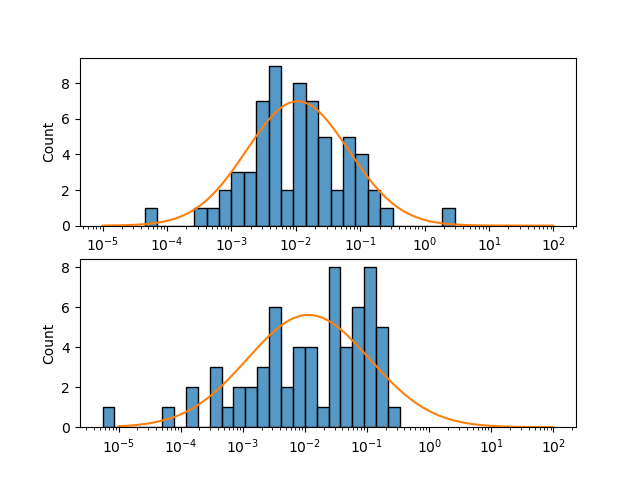

Obs scale:  0.010683098228410529
Mod scale:  0.011391395526692464
Obs shape:  1.825798207580488
Mod shape:  2.2743573575504534


In [58]:
import seaborn as sns
import scipy.stats

fig,axs=plt.subplots(2,1)

mp=manta_pred_master
sel_tau=mp.tau==10
sel_smooth=mp.Msmooth_label=='constant'
sel_step=mp.step==0
sel_storm=mp.storm_factor==0.01
sel=sel_tau & sel_smooth & sel_step & sel_storm
df=manta_pred_master[sel]

nz=df['part_per_m2_nofiber']>0
kde=False
ret=sns.histplot(df['part_per_m2_nofiber'][nz],
                 log_scale=True,kde=kde,bins=25,ax=axs[0])
shape,loc,scale=stats.lognorm.fit(df['part_per_m2_nofiber'][nz],floc=0)
x=10**np.linspace(-5,2,300)
ln_pred=stats.lognorm.pdf(x,shape,loc=loc,scale=scale)
axs[0].plot(x,x*ln_pred*nz.sum()/2,color='tab:orange',label='Log-normal')

# ---- same, for model output
pred=df['C_model'].values
pred=pred[pred>0]

ret=sns.histplot(pred,log_scale=True,kde=kde,bins=25,ax=axs[1])
m_shape,m_loc,m_scale=stats.lognorm.fit(pred,floc=0)
ln_pred=stats.lognorm.pdf(x,m_shape,loc=m_loc,scale=m_scale)
axs[1].plot(x,x*ln_pred*nz.sum()/2,color='tab:orange',label='Log-normal')

print("Obs scale: ",scale)
print("Mod scale: ",m_scale)
print("Obs shape: ",shape)
print("Mod shape: ",m_shape)

In [32]:
mp.columns

Index(['idx', 'storm_factor', 'tau', 'step', 'Msmooth_i', 'C_model',
       'SampleID', 'SAMPLE LOCATION', 'DATE', 'TYPE', 'LAT START',
       'LONG START', 'LAT END', 'LONG END', 'TOTAL DIST (M)', 'START FLOW',
       'END FLOW', 'area_km2', 'volume_m3', 'FibersYN', 'Season', 'time_local',
       'time_utc', 'lat', 'lon', 'volume_l', 'area_m2', 'count_preblank_std',
       'count_preblank_nofiber', 'Fiber', 'Fiber Bundle', 'Film', 'Foam',
       'Fragment', 'Sphere', 'Fiber_adj', 'Fiber Bundle_adj', 'Fragment_adj',
       'Foam_adj', 'Film_adj', 'Sphere_adj', 'count_std', 'count_nofiber',
       'part_per_m3_std', 'part_per_m2_std', 'part_per_m3_raw_std',
       'part_per_m2_raw_std', 'part_per_m3_nofiber', 'part_per_m2_nofiber',
       'part_per_m3_raw_nofiber', 'part_per_m2_raw_nofiber', 'x', 'y',
       'Msmooth_label'],
      dtype='object')